In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn.metrics as metrics

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import StratifiedKFold
from pandas_ml import ConfusionMatrix

from sklearn.neighbors import NearestCentroid

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import SimpleRNN
from keras import initializers
from keras.optimizers import RMSprop

from sklearn.cross_validation import ShuffleSplit
from sklearn.model_selection import train_test_split

import sklearn.metrics as metrics
import tensorflow as tf

from features import round_up_rows
from pandas_ml import ConfusionMatrix
from utils import auc

/home/kurbanov/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
def get_metrics(Y_test, Y_pred):
    ypreds = np.argmax(Y_pred, axis=1)
    ytrue = np.argmax(Y_test, axis=1)
    if sum(ytrue) == 0:
        return -1, -1, -1, -1, -1
    
    auc = metrics.roc_auc_score(Y_test[:, 1], Y_pred[:, 1])
    acc = metrics.accuracy_score(ytrue, ypreds)
    prec = metrics.average_precision_score(ytrue, ypreds)
    recall = metrics.recall_score(ytrue, ypreds)
    binary_confusion_matrix = ConfusionMatrix(ytrue, ypreds)
    return acc, auc, prec, recall, binary_confusion_matrix
    
def test_classifier(clf, X, Y):
    aucs = []
    precs = []
    recalls = []
    
    sky = np.argmax(Y, axis=1)
    if sum(sky) == 0:
        return -1, -1, -1, -1
    
    skf = StratifiedKFold(sky, n_folds=5, random_state=0)
    for train_index, test_index in skf:
        X_train, X_test, Y_train, Y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]
        Y_pred = clf.predict(X_test)
  
        auc, prec, recall = get_metrics(Y_test, Y_pred)        
        aucs.append(auc)
        precs.append(prec)
        recalls.append(recall)
    #     break

    mean_auc = np.mean(aucs)
    mean_prec = np.mean(precs)
    mean_recall = np.mean(recalls)

    ypreds = np.argmax(Y_pred, axis=1)
    ytrue = np.argmax(Y_test, axis=1)
    binary_confusion_matrix = ConfusionMatrix(ytrue, ypreds)

    return mean_auc, mean_prec, mean_recall, binary_confusion_matrix

def scores_on_train(clf, X, Y):
    sky = np.argmax(Y, axis=1)
    if sum(sky) == 0:
        return -1, -1, -1, -1

    Y_pred = clf.predict(X)
    auc, prec, recall =  get_metrics(Y, Y_pred)        
    
    ypreds = np.argmax(Y_pred, axis=1)
    ytrue = np.argmax(Y, axis=1)
    binary_confusion_matrix = ConfusionMatrix(ytrue, ypreds)
    
    return auc, prec, recall, binary_confusion_matrix

In [3]:
nrows = 500000
features_df = pd.read_csv("../features/feaures_pyAA_all_10ms.csv", nrows=nrows)
features_df = round_up_rows(features_df)

# features_df = pd.read_csv("../features/feaures_pyAA_all_10ms.csv")

In [4]:
features_df.shape

(499400, 104)

In [5]:
mini_df = features_df

In [6]:
nfeatures = mini_df.shape[1] - 2
X = mini_df.iloc[:, :nfeatures].as_matrix()
Y = mini_df.IS_LAUGHTER.as_matrix()

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = Y

In [8]:
X.shape

(499400, 102)

In [9]:
train_until = int(len(X) * 0.8)
val_until = int(len(X) * 0.9)
x_train, x_val, x_test = X[:train_until, :], X[train_until+1:val_until, :], X[val_until+1:, :]
y_train, y_val, y_test = y[:train_until], y[train_until+1:val_until], y[val_until+1:]

In [10]:
# pd.DataFrame(y_train).describe()
# pd.DataFrame(y_val).describe()
# pd.DataFrame(y_train).describe()

In [11]:
batch_size = 1100
num_classes = 2
epochs = 30
hidden_units = 100

learning_rate = 1e-6
clip_norm = 1.0

# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
# x_train = x_train.reshape(x_train.shape[0], -1, 1)
# x_test = x_test.reshape(x_test.shape[0], -1, 1)

x_train = x_train.reshape(x_train.shape[0], -1, 1)
x_val = x_val.reshape(x_val.shape[0], -1, 1)
x_test = x_test.reshape(x_test.shape[0], -1, 1)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (399520, 102, 1)
y_train shape: (399520,)
x_val shape: (49939, 102, 1)
y_val shape: (49939,)
x_test.shape: (49939, 102, 1)
y_test.shape: (49939,)
399520 train samples
49939 test samples


In [12]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [13]:
class LossHistory(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
#         print("\n=====", "TRAIN", "=====\n")
#         y_pred = model.predict(x_train)
# #         mean_auc, mean_prec, mean_recall, binary_confusion_matrix = test_classifier(model, x_train, y_train)
#         acc, auc, prec, recall, binary_confusion_matrix = get_metrics(y_train, y_pred)
#         print(binary_confusion_matrix)
#         print("ACC   :", acc)
#         print("AUC   :", auc)
#         print("PREC  :", prec)
#         print("RECALL:", recall)

        print("\n=====", "VALIDATION", "=====\n")
        y_pred = model.predict(x_val)
#         mean_auc, mean_prec, mean_recall, binary_confusion_matrix = test_classifier(model, x_train, y_train)
        acc, auc, prec, recall, binary_confusion_matrix = get_metrics(y_val, y_pred)
        print(binary_confusion_matrix)
        print("ACC   :", acc)
        print("AUC   :", auc)
        print("PREC  :", prec)
        print("RECALL:", recall)

In [14]:
# convert class vectors to binary class matrices
print('Evaluate IRNN...')
model = Sequential()
model.add(SimpleRNN(hidden_units,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=x_train.shape[1:]))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
rmsprop = RMSprop(lr=learning_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy', auc])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val),
#           validation_data=(x_test, y_test))
          callbacks=[LossHistory()])
#           class_weight={0 : 1., 1 : 100.})

scores = model.evaluate(x_test, y_test, verbose=1)
print('IRNN test score:', scores[0])
print('IRNN test accuracy:', scores[1])

Evaluate IRNN...
Train on 399520 samples, validate on 49939 samples
Epoch 1/30
399300/399520 [============================>.] - ETA: 0s - loss: 0.4677 - acc: 0.9666 - auc: 0.9642
===== VALIDATION =====

Predicted      0  1  __all__
Actual                      
0          47552  0    47552
1           2387  0     2387
__all__    49939  0    49939
ACC   : 0.952201686057
AUC   : 0.657062485622
PREC  : 0.523899156972
RECALL: 0.0
399520/399520 [==============================] - 59s - loss: 0.4675 - acc: 0.9667 - auc: 0.9642 - val_loss: 0.2162 - val_acc: 0.9522 - val_auc: 0.9630
Epoch 2/30
399300/399520 [============================>.] - ETA: 0s - loss: 0.1384 - acc: 0.9675 - auc: 0.9808
===== VALIDATION =====

Predicted      0  1  __all__
Actual                      
0          47552  0    47552
1           2387  0     2387
__all__    49939  0    49939
ACC   : 0.952201686057
AUC   : 0.754628443535
PREC  : 0.523899156972
RECALL: 0.0
399520/399520 [==============================] - 47s - loss

In [15]:
print("finished")

finished


In [16]:
print("\n=====", "TRAIN", "=====\n")
y_pred = model.predict(x_train)
#         mean_auc, mean_prec, mean_recall, binary_confusion_matrix = test_classifier(model, x_train, y_train)
acc, auc, prec, recall, binary_confusion_matrix = get_metrics(y_train, y_pred)
print(binary_confusion_matrix)
print("ACC   :", acc)
print("AUC   :", auc)
print("PREC  :", prec)
print("RECALL:", recall)



===== TRAIN =====

Predicted       0  1  __all__
Actual                       
0          386528  0   386528
1           12992  0    12992
__all__    399520  0   399520
ACC   : 0.967480977173
AUC   : 0.76900335793
PREC  : 0.516259511414
RECALL: 0.0


In [25]:
y_pred = model.predict(x_test)

In [28]:
# y_score.shape
# y_expected.shape

(49939,)

In [34]:
from sklearn.metrics import roc_curve, auc


y_score = y_pred
y_expected = y_test
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], thresholds = roc_curve(y_expected[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/home/kurbanov/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


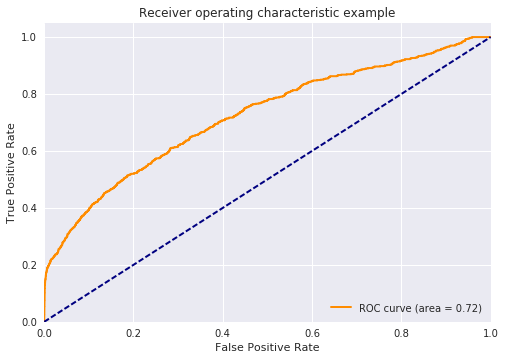

In [35]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [49]:
roc_df = pd.DataFrame({'tpr' : tpr[1], 'fpr' : fpr[1], 'treshhold' : thresholds})
roc_df[roc_df.tpr >= 0.6].head()

fpr       tpr  treshhold
821  0.279937  0.600000   0.036123
822  0.280241  0.600000   0.036081
823  0.280241  0.601361   0.036077
824  0.280770  0.601361   0.036009
825  0.280770  0.602721   0.036005

In [50]:
best_treshhold = 0.036123

In [53]:
print(y_pred.shape)
print(y_test.shape)

(49939, 2)
(49939, 2)


In [54]:
# y_test[:, 1]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [56]:
best_treshhold = 0.036123

ypreds = np.where(y_pred[:, 1] >= best_treshhold, np.ones(len(y_pred)), np.zeros(len(y_pred)))
# ypreds = np.argmax(Y_pred, axis=1)
ytrue = y_test[:, 1]
# if sum(ytrue) == 0:
#     return -1, -1, -1, -1, -1

# auc = metrics.roc_auc_score(Y_test[:, 1], Y_pred[:, 1])
acc = metrics.accuracy_score(ytrue, ypreds)
prec = metrics.average_precision_score(ytrue, ypreds)
recall = metrics.recall_score(ytrue, ypreds)
binary_confusion_matrix = ConfusionMatrix(ytrue, ypreds)
acc, auc, prec, recall, binary_confusion_matrix

print(binary_confusion_matrix)
print("ACC: ", acc)
print("PREC: ", prec)
print("RECALL: ", recall)

Predicted    0.0    1.0  __all__
Actual                          
0.0        35430  13774    49204
1.0          294    441      735
__all__    35724  14215    49939
ACC:  0.718296321512
PREC:  0.318455374509
RECALL:  0.6


In [57]:
# model.save('../models/rnn_model_0.5kk_new_features.h5')  # creates a HDF5 file 'my_model.h5'


In [16]:
mean_auc, mean_prec, mean_recall, binary_confusion_matrix = test_classifier(model, x_train, y_train)
print(binary_confusion_matrix)
print("AUC: ", mean_auc)
print("PREC: ", mean_prec)
print("RECALL: ", mean_recall)

Predicted      0  1  __all__
Actual                      
0          77305  0    77305
1           2598  0     2598
__all__    79903  0    79903
AUC:  0.747805488223
PREC:  0.516259511384
RECALL:  0.0


In [17]:
model.evaluate(x_test, y_test, verbose=1)

49939/49939 [==============================] - 207s   


[0.080209311254774734, 0.98528204409379438, 0.98568566150703862]

In [63]:
model.metrics_names

['loss', 'acc', 'auc']

In [64]:
Y_pred = model.predict(x_test)
# get_metrics(y_test, Y_pred)
ypreds = np.argmax(Y_pred, axis=1)
ytrue = np.argmax(y_test, axis=1)
acc = metrics.accuracy_score(ytrue, ypreds)
acc

0.98528204409379438

array([[ 0.91130728,  0.08869274],
       [ 0.93148494,  0.06851499],
       [ 0.9536134 ,  0.04638662],
       ..., 
       [ 0.99609536,  0.00390465],
       [ 0.99640143,  0.00359853],
       [ 0.99710482,  0.00289512]], dtype=float32)

In [18]:
model.metrics_names

['loss', 'acc', 'auc']

In [25]:
def test_classifier():
    clf, X, Y = model, x_test, y_test

    aucs = []
    precs = []
    recalls = []

    sky = np.argmax(Y, axis=1)
    if sum(sky) == 0:
        return -1, -1, -1, -1

    skf = StratifiedKFold(sky, n_folds=5, random_state=0)
    for train_index, test_index in skf:
        X_train, X_test, Y_train, Y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]
        Y_pred = clf.predict(X_test)
        print(Y_pred)
        
        auc, prec, recall = get_metrics(Y_test, Y_pred)        
        aucs.append(auc)
        precs.append(prec)
        recalls.append(recall)
        break

    mean_auc = np.mean(aucs)
    mean_prec = np.mean(precs)
    mean_recall = np.mean(recalls)

    ypreds = np.argmax(Y_pred, axis=1)
    ytrue = np.argmax(Y_test, axis=1)
    binary_confusion_matrix = ConfusionMatrix(ytrue, ypreds)

    return mean_auc, mean_prec, mean_recall, binary_confusion_matrix

In [26]:
# mean_auc, mean_prec, mean_recall, binary_confusion_matrix = test_classifier(model, x_test, y_test)
mean_auc, mean_prec, mean_recall, binary_confusion_matrix = test_classifier()

print(binary_confusion_matrix)
print("AUC   :", mean_auc)
print("PREC  :", mean_prec)
print("RECALL:", mean_recall)


[[ 0.91130728  0.08869274]
 [ 0.93148494  0.06851499]
 [ 0.9536134   0.04638662]
 ..., 
 [ 0.99705541  0.00294458]
 [ 0.99687743  0.0031226 ]
 [ 0.99681133  0.00318863]]
Predicted     0  1  __all__
Actual                     
0          9841  0     9841
1           147  0      147
__all__    9988  0     9988
AUC   : 0.587098125502
PREC  : 0.507358830597
RECALL: 0.0


In [ ]:
def get_metrics(Y_test, Y_pred):
    auc = metrics.roc_auc_score(Y_test[:, 1], Y_pred[:, 1])
    ypreds = np.argmax(Y_pred, axis=1)
    ytrue = np.argmax(Y_test, axis=1)
    acc = metrics.accuracy_score(ytrue, ypreds)
    prec = metrics.average_precision_score(ytrue, ypreds)
    recall = metrics.recall_score(ytrue, ypreds)
    return acc, auc, prec, recall


In [34]:
Y_pred = model.predict(x_test)

In [49]:
ys = Y_pred

In [54]:
ys[:, 1] 

array([ 0.08869274,  0.06851499,  0.04638662, ...,  0.00390465,
        0.00359853,  0.00289512], dtype=float32)

In [53]:
# y_test

In [55]:
ys
yys = np.where(ys[:, 1] > 0.03, np.ones(len(ys)), np.zeros(len(ys)))
yys

array([ 1.,  1.,  1., ...,  0.,  0.,  0.])

In [56]:
pd.DataFrame(yys).describe()

0
count  49939.000000
mean       0.417169
std        0.493096
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

In [57]:
x = np.argmax(y_test, axis=1)
metrics.average_precision_score(x, x)
metrics.recall_score(x, x)

1.0

In [59]:
model.__dict__

{'_built': True,
 '_feed_input_names': ['simple_rnn_1_input'],
 '_feed_inputs': [<tf.Tensor 'simple_rnn_1_input:0' shape=(?, 102, 1) dtype=float32>],
 '_initial_weights': None,
 '_output_mask_cache': {'139691128480488_139693344388208': None},
 '_output_shape_cache': {},
 '_output_tensor_cache': {},
 '_trainable': True,
 'container_nodes': {'activation_1_ib-0',
  'dense_1_ib-0',
  'simple_rnn_1_ib-0',
  'simple_rnn_1_input_ib-0'},
 'inbound_nodes': [<keras.engine.topology.Node at 0x7f0c60116080>],
 'input_layers': [<keras.engine.topology.InputLayer at 0x7f0c60150898>],
 'input_layers_node_indices': [0],
 'input_layers_tensor_indices': [0],
 'input_names': ['simple_rnn_1_input'],
 'inputs': [<tf.Tensor 'simple_rnn_1_input:0' shape=(?, 102, 1) dtype=float32>],
 'layers': [<keras.layers.recurrent.SimpleRNN at 0x7f0c601507b8>,
 'loss': 'categorical_crossentropy',
 'loss_weights': None,
 'metrics': ['accuracy', <function utils.auc>],
 'metrics_names': ['loss', 'acc', 'auc'],
 'metrics_tensor